In [14]:
# Необходимо получить три временные матрицы для трех режимов - "разгон", "подъем", "разгон-подъём"
# Для этого необходимо провести аппроксимации некоторых других функций, помимо тех, что мы получили в предыдущий раз
# Аппроксимацию будем проводить для высот в диапазоне от 700м до 8000м

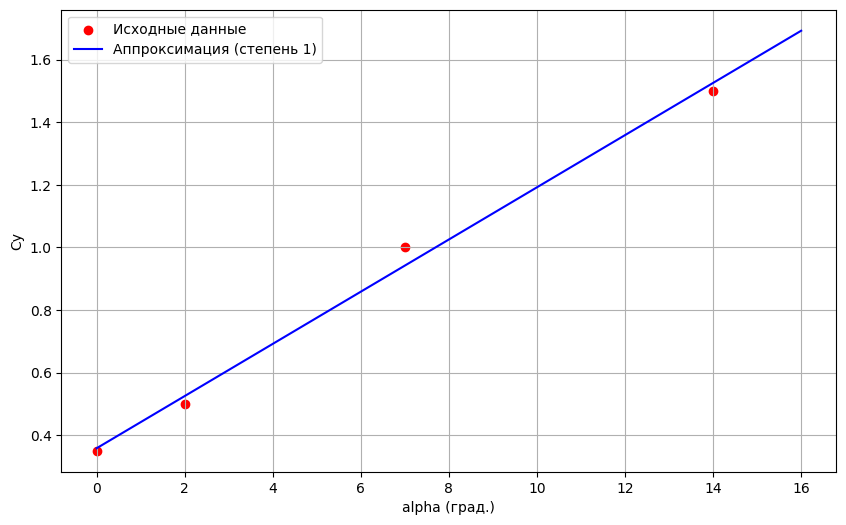

Получаем функцию: Сy(alpha) = 0.0834*alpha + 0.3579


In [15]:
# Воспользуюсь ранее реализованными функциями
import functions

import numpy as np

# Аппроксимация коэффециента подъёмной силы Cy от угла атаки alpha (возьму при delta = 20)

Cy = np.array([0.35, 0.5, 1, 1.5])
alpha = np.array([0, 2, 7, 14])

degree = 1  # Выбираем степень полинома

coeffs = functions.least_squares_fit(alpha, Cy, degree)

# Создание полинома на основе коэффициентов
poly = np.poly1d(coeffs)

# Генерация значений для аппроксимации
alpha_range = np.arange(0, 16 + 1, 1) # Интервал каждый градус
Cy_approximated = poly(alpha_range)

# Визуализация результатов
functions.plot_result(alpha, Cy, alpha_range, Cy_approximated, degree, 'alpha (град.)', 'Cy')

print(f'Получаем функцию: Сy(alpha) = {round(coeffs[0], 4)}*alpha + {round(coeffs[1], 4)}')

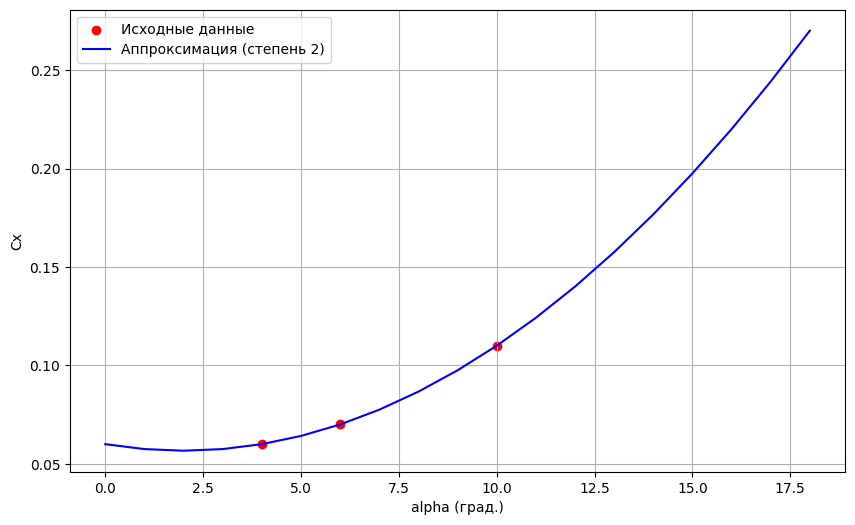

Получаем функцию: Сx(alpha) = 0.0008*alpha^2 + -0.0033*alpha + 0.06


In [16]:
# Аппроксимация коэффециента лобового сопротивления Cx от угла атаки alpha (возьму при delta = 20)

Cx = np.array([0.06, 0.07, 0.11])
alpha = np.array([4, 6, 10])

degree = 2  # Выбираем степень полинома

coeffs = functions.least_squares_fit(alpha, Cx,  degree)

# Создание полинома на основе коэффициентов
poly = np.poly1d(coeffs)

# Генерация значений для аппроксимации
alpha_range = np.arange(0, 18 + 1, 1) # Интервал каждый градус
Cx_approximated = poly(alpha_range)

# Визуализация результатов
functions.plot_result(alpha, Cx, alpha_range, Cx_approximated, degree, 'alpha (град.)', 'Cx')

print(f'Получаем функцию: Сx(alpha) = {round(coeffs[0], 4)}*alpha^2 + {round(coeffs[1], 4)}*alpha + {round(coeffs[2], 4)}')


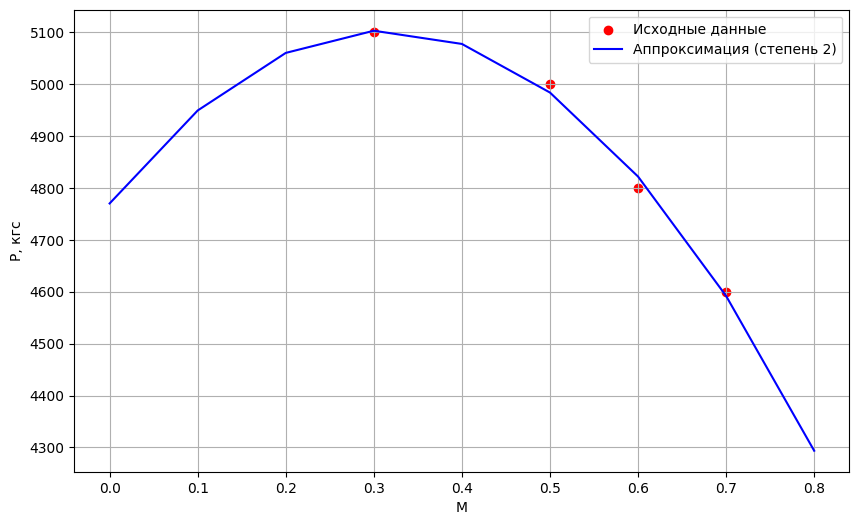

Получаем функцию: P(M) = -3409*M^2 + 2131.82*M + 4770


In [23]:
# Аппроксимация тяги двигателя P от скорости полета M
# В результате получим зависимость тяги P от М, которая в свою очередь зависит от высоты полета 

P = np.array([5100, 5000, 4800, 4600])
M = np.array([0.3, 0.5, 0.6, 0.7])

degree = 2  # Выбираем степень полинома

coeffs = functions.least_squares_fit(M, P,  degree)

# Создание полинома на основе коэффициентов
poly = np.poly1d(coeffs)

# Генерация значений для аппроксимации
M_range = np.arange(0, 0.9, 0.1) # Интервал каждый градус
P_approximated = poly(M_range)

# Визуализация результатов
functions.plot_result(M, P, M_range, P_approximated, degree, 'M', 'P, кгс')

print(f'Получаем функцию: P(M) = {round(coeffs[0])}*M^2 + {round(coeffs[1], 2)}*M + {round(coeffs[2])}')

In [18]:
from math import cos, log
import approximated

# Теперь мы располагаем всеми необходимыми зависимостями
# Реализация функций расчета времени в разных режимах

def razgon(H, V1, V2, mass, S, phi=0):
    """
    Режим разгон
    :param H: высота полета = const 
    :param V1: начальная скорость
    :param V2: конечная скорость
    :param mass: масса ЛА
    :param S: приведенная площадь
    :param phi: угол наклона двигателя
    :return: время для режима "разгон"
    """
    V = (V1 + V2) / 2
    
    ro = approximated.ro(H)
    g = approximated.g(H)
    sound_of_speed = approximated.sound_speed(H)
    M = V / sound_of_speed
    P = approximated.P_v(M)
    # Сy(alpha) = 0.0834*alpha + 0.3579
    Cya = 0.0834
    Cy0 = 0.3579
    alpha = (mass * g - (P * phi/ 57.3) - Cy0 * ro * V ** 2 / 2 * S) / (P / 57.3 + Cya * ro * V ** 2 / 2 * S)
    Cx = approximated.Cx(alpha)
    return abs((mass * (V2 - V1)) / (P * cos(alpha) - Cx * V ** 2 * ro / 2 * S))


def pod(H1, H2, V, mass, S, phi=0):
    """
    Режим подъём
    :param H1: начальная высота полета
    :param H2: конечная высота полета
    :param V: скорость ЛА = const
    :param mass: масса ЛА
    :param S: приведенная площадь
    :param phi: угол наклона двигателя
    :return: время для режима "подъём"
    """
    H = (H1 + H2) / 2
    
    ro = approximated.ro(H)
    g = approximated.g(H)
    speed_of_sound = approximated.sound_speed(H)
    M = V / speed_of_sound
    P = approximated.P_v(M)
    # Сy(alpha) = 0.0834*alpha + 0.3579
    Cya = 0.0834
    Cy0 = 0.3579
    alpha = (mass * g - (P * phi / 57.3) - Cy0 * ro * V ** 2 / 2 * S) / (P / 57.3 + Cya * ro * V ** 2 / 2 * S)
    Cx = approximated.Cx(alpha)
    X = Cx * V ** 2 * ro / 2 * S
    teta = ((P - X) * 57.3) / (mass * g)
    return abs((57.3 * (H2 - H1)) / (V * teta))


def raz_pod(H1, H2, V1, V2, mass, S, phi=0):
    """
    Режим разгон-подъём
    :param H1: начальная высота полёта
    :param H2: конечаня высота полёта
    :param V1: начальная скорость ЛА
    :param V2: конечная скорость ЛА
    :param mass: масса ЛА
    :param S: приведенная площадь
    :param phi: угол наклона двигателя
    :return: время для режима "разгон-подъём"
    """
    V = (V1 + V2) / 2
    H = (H1 + H2) / 2

    ro = approximated.ro(H)
    g = approximated.g(H)
    speed_of_sound = approximated.sound_speed(H)
    M = V / speed_of_sound
    P = approximated.P_v(M)
    # Сy(alpha) = 0.0834*alpha + 0.3579
    Cya = 0.0834
    Cy0 = 0.3579
    alpha = (mass * g - (P * phi / 57.3) - Cy0 * ro * V ** 2 / 2 * S) / (P / 57.3 + Cya * ro * V ** 2 / 2 * S)
    Cx = approximated.Cx(alpha)
    
    k = (V2 - V1) / (H2 - H1)
    X = Cx * V ** 2 * ro / 2 * S
    sin_teta = (P * cos(alpha) - X) / (mass * (k * V + g))
    return abs(1 / (k * sin_teta) * log(V2 / V1))

In [22]:
# Создание и наполнение временных матриц

import pandas as pd

# Параметры ЛА
mass = 47000 # кг
S = 127 # м^2
phi = 0

n = 10
Vn = 350 * 1000 / 3600  # из км/ч в м/с
Vk = 880 * 1000 / 3600
Hn = 500
Hk = 8000
deltaV = (Vk - Vn) / n  # приращение скорости
deltaH = (Hk - Hn) / n  # приращение высоты

# Создаем временные матрицы Tr, Tp, Trp
Tr = np.zeros((n, n + 1))  # Матрица Tr
Tp = np.zeros((n + 1, n))  # Матрица Tp
Trp = np.zeros((n, n))  # Матрица Trp

# Заполняем матрицу Tr
for i in range(n + 1):
    Hi = Hn + i * deltaH
    for j in range(n):
        Vi = Vn + j * deltaV
        Traz = razgon(Hi, Vi, Vi + deltaV, mass, S, phi)
        Tr[j, i] = Traz

# Заполняем матрицу Tp
for i in range(n + 1):
    Vi = Vn + i * deltaV
    for j in range(n):
        Hi = Hn + j * deltaH
        Tpod = pod(Hi, Hi + deltaH, Vi, mass, S, phi)
        Tp[i, j] = Tpod

# Заполняем матрицу Trp
for i in range(n):
    Vi = Vn + i * deltaV
    for j in range(n):
        Hi = Hn + j * deltaH
        Traz_pod = raz_pod(Hi, Hi + deltaH, Vi, Vi + deltaV, mass, S, phi)
        Trp[i, j] = Traz_pod

df_Tr = pd.DataFrame(Tr)
df_Tp = pd.DataFrame(Tp)
df_Trp = pd.DataFrame(Trp)

print("Матрица Tr:")
print(df_Tr.to_string(index=False))  # Использую to_string() для вывода в виде текста
print("\nМатрица Tp:")
print(df_Tp.to_string(index=False))
print("\nМатрица Trp:")
print(df_Trp.to_string(index=False))

Матрица Tr:
       0         1         2         3         4          5         6          7         8         9         10
 7.885912  7.273064  7.783148 10.411090 21.667065 401.341037 43.286989 322.427765 15.107891  8.139973  7.941614
23.329393 15.961872 11.273727  8.670979  7.462349   7.394332  8.878517  14.623469 59.114948 54.670493 58.812882
24.030449 31.334733 31.862044 24.283940 16.440030  11.456778  8.744291   7.503319  7.403947  8.715368 13.254120
 9.494050 12.735898 17.898755 25.347976 31.824617  29.829633 21.601326  14.670814 10.547121  8.375043  7.452066
 5.396146  6.527823  8.203429 10.796107 14.927080  21.276916 28.755721  31.153042 25.186390 17.686164 12.598570
 3.812817  4.360406  5.099679  6.136927  7.653758   9.964041 13.581743  19.112455 26.092049 30.241356 27.076784
 3.002426  3.334141  3.752515  4.296346  5.027030   6.044171  7.512240   9.701058 13.018121 17.881247 23.916968
 2.502762  2.736342  3.016629  3.360875  3.794778   4.357271  5.108242   6.140685  7.598128 